In [1]:
import os
import pydicom
from pydicom.pixel_data_handlers.util import apply_modality_lut

import numpy as np
import scipy.io as sio
import tensorflow as tf
import matplotlib.pyplot as plt
import ipywidgets as widgets

from itertools import cycle
from time import process_time

In [2]:
# Set CPU as available physical device
tf.config.experimental.set_visible_devices([], 'GPU')

In [3]:
import tf2lib as tl
import DLlib as dl
import pylib as py
import wflib as wf
import data

In [4]:
file_dir = "C:/Users/jpmen/OneDrive - Universidad Católica de Chile/Documents/MRI-Datasets/Anon_JGalgani/004/2D_NSA1_24S_2MM_IM_0007_anon/2D_NSA1_24S_2MM_IM_0007_anon.mat"

mat = sio.loadmat(file_dir)
if 'imDataParams' in mat.keys():
    acq = mat['imDataParams'][0,0][0].astype('complex64')
    TE = mat['imDataParams'][0,0][1].astype('float32')
elif 'imDataAll' in  mat.keys():
    acq = mat['imDataAll'][0,0][4].astype('complex64')
    TE = mat['imDataAll'][0,0][2].astype('float32') #0
if acq.shape[0] % 16 != 0.0:
    acq = acq[:(acq.shape[0]-acq.shape[0]%16)]
acq = np.transpose(acq, (2,4,0,1,3)) / np.max(np.abs(acq))
acq_real = np.real(acq)
acq_imag = np.imag(acq)
X = np.concatenate((acq_real,acq_imag),axis=-1)
X = np.flip(X,axis=0)
TE = np.expand_dims(TE,axis=-1)

In [8]:
X.shape

(20, 6, 384, 384, 2)

In [9]:
# Build tensorflow dataset
hgt = X.shape[2]
wdt = X.shape[3]
n_ch = X.shape[4]
TEs = tf.repeat(TE, [X.shape[0]], axis=0)
A_dataset = tf.data.Dataset.from_tensor_slices((X,TEs))
test_iter = cycle(A_dataset)

In [10]:
model_fn = 'GAN-813'
experiment_dir = py.join('output',model_fn)
args = py.args_from_yaml(py.join(experiment_dir, 'settings.yml'))

In [12]:
enc= dl.encoder(input_shape=(None,hgt,wdt,n_ch),
                encoded_dims=args.encoded_size,
                filters=64,
                num_layers=args.n_downsamplings,
                num_res_blocks=args.n_res_blocks,
                sd_out=not(args.VQ_encoder),
                ls_mean_activ=None,
                NL_self_attention=args.NL_SelfAttention
                )
vq_op = dl.VectorQuantizer(args.encoded_size, args.VQ_num_embed, args.VQ_commit_cost)

tl.Checkpoint(dict(enc=enc,vq_op=vq_op), py.join(experiment_dir, 'checkpoints')).restore()

In [18]:
@tf.function
def sample(A):
    A2Z = enc(A, training=False)
    if args.VQ_encoder:
        vq_dict = vq_op(A2Z)
        A2Z = vq_dict['quantize']
    return A2Z

def test(A):
    A2Z = sample(A)
    return A2Z

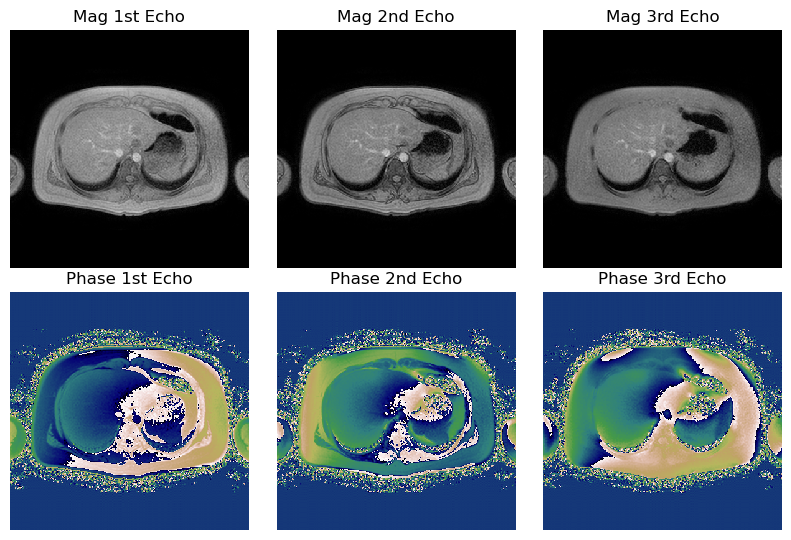

In [30]:
A, TE = next(test_iter)
A = tf.expand_dims(A,axis=0)
TE = tf.expand_dims(TE,axis=0)

# CSE-MR images at each echo
mag_ech1 = np.squeeze(np.abs(tf.complex(A[:,0,:,:,0],A[:,0,:,:,1])))
pha_ech1 = np.squeeze(np.arctan2(A[:,0,:,:,1],A[:,0,:,:,0]))
mag_ech2 = np.squeeze(np.abs(tf.complex(A[:,1,:,:,0],A[:,1,:,:,1])))
pha_ech2 = np.squeeze(np.arctan2(A[:,1,:,:,1],A[:,1,:,:,0]))
mag_ech3 = np.squeeze(np.abs(tf.complex(A[:,2,:,:,0],A[:,2,:,:,1])))
pha_ech3 = np.squeeze(np.arctan2(A[:,2,:,:,1],A[:,2,:,:,0]))

fig, axs = plt.subplots(figsize=(8, 5), nrows=2, ncols=3)

# Acquisitions in the first row
acq_ech1 = axs[0,0].imshow(mag_ech1, cmap='gray',
                      interpolation='none', vmin=0, vmax=1)
axs[0,0].set_title('Mag 1st Echo')
axs[0,0].axis('off')
acq_ech2 = axs[1,0].imshow(pha_ech1/np.pi, cmap='gist_earth',
                      interpolation='none', vmin=-1, vmax=1)
axs[1,0].set_title('Phase 1st Echo')
axs[1,0].axis('off')
acq_ech3 = axs[0,1].imshow(mag_ech2, cmap='gray',
                          interpolation='none', vmin=0, vmax=1)
axs[0,1].set_title('Mag 2nd Echo')
axs[0,1].axis('off')
acq_ech4 = axs[1,1].imshow(pha_ech2/np.pi, cmap='gist_earth',
                          interpolation='none', vmin=-1, vmax=1)
axs[1,1].set_title('Phase 2nd Echo')
axs[1,1].axis('off')
acq_ech5 = axs[0,2].imshow(mag_ech3, cmap='gray',
                          interpolation='none', vmin=0, vmax=1)
axs[0,2].set_title('Mag 3rd Echo')
axs[0,2].axis('off')
acq_ech6 = axs[1,2].imshow(pha_ech3/np.pi, cmap='gist_earth',
                          interpolation='none', vmin=-1, vmax=1)
axs[1,2].set_title('Phase 3rd Echo')
axs[1,2].axis('off')

plt.subplots_adjust(top=1,bottom=0,right=1,left=0,hspace=0.1,wspace=0)
tl.make_space_above(axs,topmargin=0.8)
fig.set_facecolor("none")
plt.show()

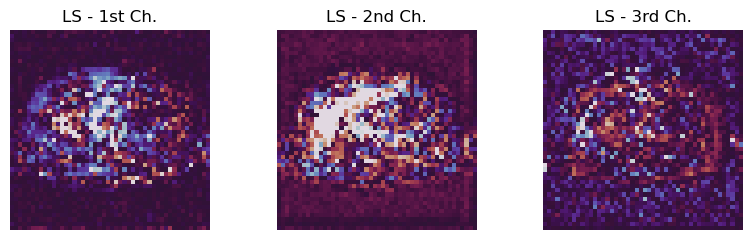

In [31]:
%timeit
A2Z = test(A)

A2Z_ch1 = np.squeeze(A2Z[...,0])
A2Z_ch2 = np.squeeze(A2Z[...,1])
A2Z_ch3 = np.squeeze(A2Z[...,2])

fig, axs = plt.subplots(figsize=(8, 2), ncols=3)
lim_val = 20

# Acquisitions in the first row
ls_ch1 = axs[0].imshow(A2Z_ch1, cmap='twilight',
                      interpolation='none', vmin=-lim_val, vmax=lim_val)
axs[0].set_title('LS - 1st Ch.')
axs[0].axis('off')
ls_ch1 = axs[1].imshow(A2Z_ch2, cmap='twilight',
                      interpolation='none', vmin=-lim_val, vmax=lim_val)
axs[1].set_title('LS - 2nd Ch.')
axs[1].axis('off')
ls_ch1 = axs[2].imshow(A2Z_ch3, cmap='twilight',
                      interpolation='none', vmin=-lim_val, vmax=lim_val)
axs[2].set_title('LS - 3rd Ch.')
axs[2].axis('off')

plt.subplots_adjust(top=1,bottom=0,right=1,left=0,hspace=0.1,wspace=0)
tl.make_space_above(axs,topmargin=0.8)
fig.set_facecolor("none")
plt.show()